In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
import blackjax
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam

/Users/madhav/anaconda3/envs/experiment-new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
def load_german_credit_data():
  data = pd.read_csv('german.data', delim_whitespace=True, header=None)
  def categorical_to_int(x):
    d = {u: i for i, u in enumerate(np.unique(x))}
    return np.array([d[i] for i in x])

  categoricals = []
  numericals = []
  numericals.append(np.ones([len(data)]))
  for column in data.columns[:-1]:
    column = data[column]
    if column.dtype == 'O':
      categoricals.append(categorical_to_int(column))
    else:
      numericals.append((column - column.mean()) / column.std())
  numericals = np.array(numericals).T
  status = np.array(data[20] == 1, dtype=np.int32)

  return jnp.array(numericals), jnp.array(categoricals), jnp.array(status)

In [4]:
numericals, categoricals, status  = load_german_credit_data()

In [5]:
x_numeric = numericals.astype(jnp.float32)
x_categorical = [jnp.eye(c.max() + 1)[c] for c in categoricals]
all_x = jnp.concatenate([x_numeric] + x_categorical, axis=1)
num_features = all_x.shape[1]
y = status[jnp.newaxis, Ellipsis]

In [6]:
def german_credit():
    mu = numpyro.sample('mu', dist.Normal(0, 10))       ## log tau0
    tau = numpyro.sample('tau', dist.Normal(mu,jnp.ones(num_features)))     ## Normal
    theta = numpyro.sample('theta', dist.Normal(jnp.zeros(num_features), jnp.exp(tau)))
    numpyro.sample('obs', dist.Bernoulli(logits = jnp.einsum('nd,md->mn', all_x, theta[jnp.newaxis, :])), obs=y)

In [7]:
num_warmup = 1000

adapt = blackjax.window_adaptation(blackjax.nuts, german_credit)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

TypeError: pow got incompatible shapes for broadcasting: (25, 62), (62, 1).

The above code will throw error because of the structure of std in this model which is not something on which the current implementation can work very well.

In [ ]:
# centeredness [0.3035308  0.03845292 0.16873685 0.96475405 0.1387696  0.9244353
#  0.35561895 0.12999162]
# centeredness [0.14344071 0.05820376 0.02024461 0.0766812  0.04357345 0.16257288
#  0.12011635 0.07107519]
# centeredness [6.1478224e-02 8.9808516e-02 1.9221745e-02 2.2248485e-06 9.3503147e-03
#  4.8371848e-02 4.3674756e-02 5.5662863e-02]
# centeredness [0.03884485 0.05708414 0.03757405 0.03870853 0.0546757  0.04828643
#  0.04516163 0.0430852 ]

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [ ]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [ ]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    samples_theta = samples['theta_decentered'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

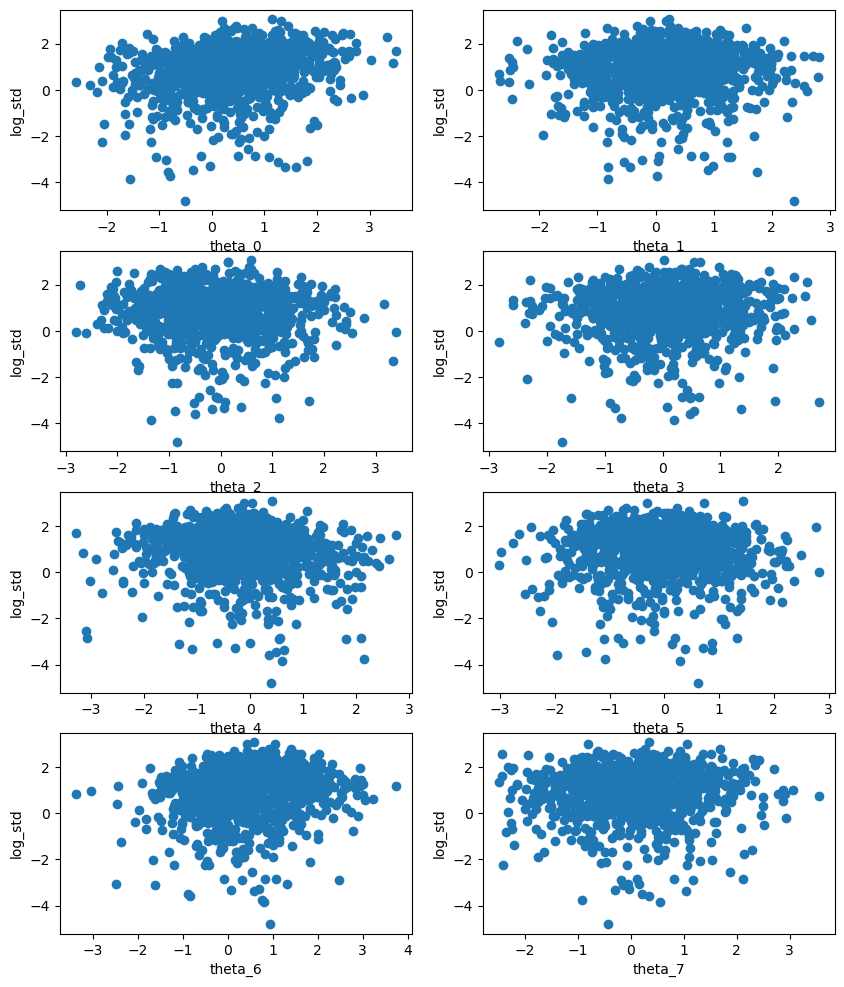

In [ ]:
scatterplt(states[0])